# HoneyBee Radiology Components - Comprehensive Testing and Visualization

This notebook demonstrates all the consolidated radiology components using real CT DICOM samples.

## 1. Setup and Imports

In [1]:
# Add HoneyBee to path
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# HoneyBee imports
from honeybee.loaders.radiology import (
    DicomLoader, 
    NiftiLoader, 
    RadiologyDataset, 
    ImageMetadata, 
    load_medical_image, 
    load_dicom_series
)

from honeybee.processors.radiology import (
    RadiologyProcessor,
    Denoiser, 
    IntensityNormalizer, 
    WindowLevelAdjuster, 
    ArtifactReducer,
    preprocess_ct, 
    preprocess_mri, 
    preprocess_pet
)

from honeybee.models.RadImageNet import RadImageNet

print("✓ Imports successful")

✓ Imports successful


## 2. Data Loading - DICOM Series

In [2]:
# Define sample data paths
ct_samples_path = Path("samples/CT")
print(f"CT samples directory: {ct_samples_path.absolute()}")

# List available CT series
ct_series = [d for d in ct_samples_path.iterdir() if d.is_dir()]
print(f"\nFound {len(ct_series)} CT series:")
for i, series in enumerate(ct_series[:5]):  # Show first 5
    print(f"  {i+1}. {series.name}")

CT samples directory: /mnt/f/Projects/HoneyBee/examples/samples/CT

Found 8 CT series:
  1. 1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915
  2. 1.3.6.1.4.1.14519.5.2.1.6450.4007.162126622221263740464333395849
  3. 1.3.6.1.4.1.14519.5.2.1.6450.4007.192159949654944985729364816700
  4. 1.3.6.1.4.1.14519.5.2.1.6450.4007.192580272562542828999316939170
  5. 1.3.6.1.4.1.14519.5.2.1.6450.4007.203200234005559533229931362134


In [3]:
# Load a DICOM series
series_path = ct_series[0] / ct_series[0].name  # Get the actual DICOM directory
print(f"Loading series from: {series_path}")

# Method 1: Using DicomLoader
dicom_loader = DicomLoader(lazy_load=False)
volume, metadata = dicom_loader.load_series(series_path)

print(f"\n✓ Loaded volume shape: {volume.shape}")
print(f"  Data type: {volume.dtype}")
print(f"  Value range: [{volume.min():.1f}, {volume.max():.1f}]")

# Display metadata
print("\nMetadata:")
print(f"  Modality: {metadata.modality}")
print(f"  Patient ID: {metadata.patient_id}")
print(f"  Study Date: {metadata.study_date}")
print(f"  Series Description: {metadata.series_description}")
print(f"  Pixel Spacing: {metadata.pixel_spacing}")
print(f"  Number of Slices: {metadata.number_of_slices}")

Loading series from: samples/CT/1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915/1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915


INFO:honeybee.loaders.radiology.loader:Auto-selected series 1.3.6.1.4.1.14519.5.2.1.6450.4007.120939979254568619864019915915 with 101 files



✓ Loaded volume shape: (101, 512, 512)
  Data type: float32
  Value range: [-2048.0, 3072.0]

Metadata:
  Modality: CT
  Patient ID: TCGA-61-1740
  Study Date: 19941028
  Series Description: ABD/PELVIS
  Pixel Spacing: (0.976562, 0.976562, 5.0)
  Number of Slices: 101


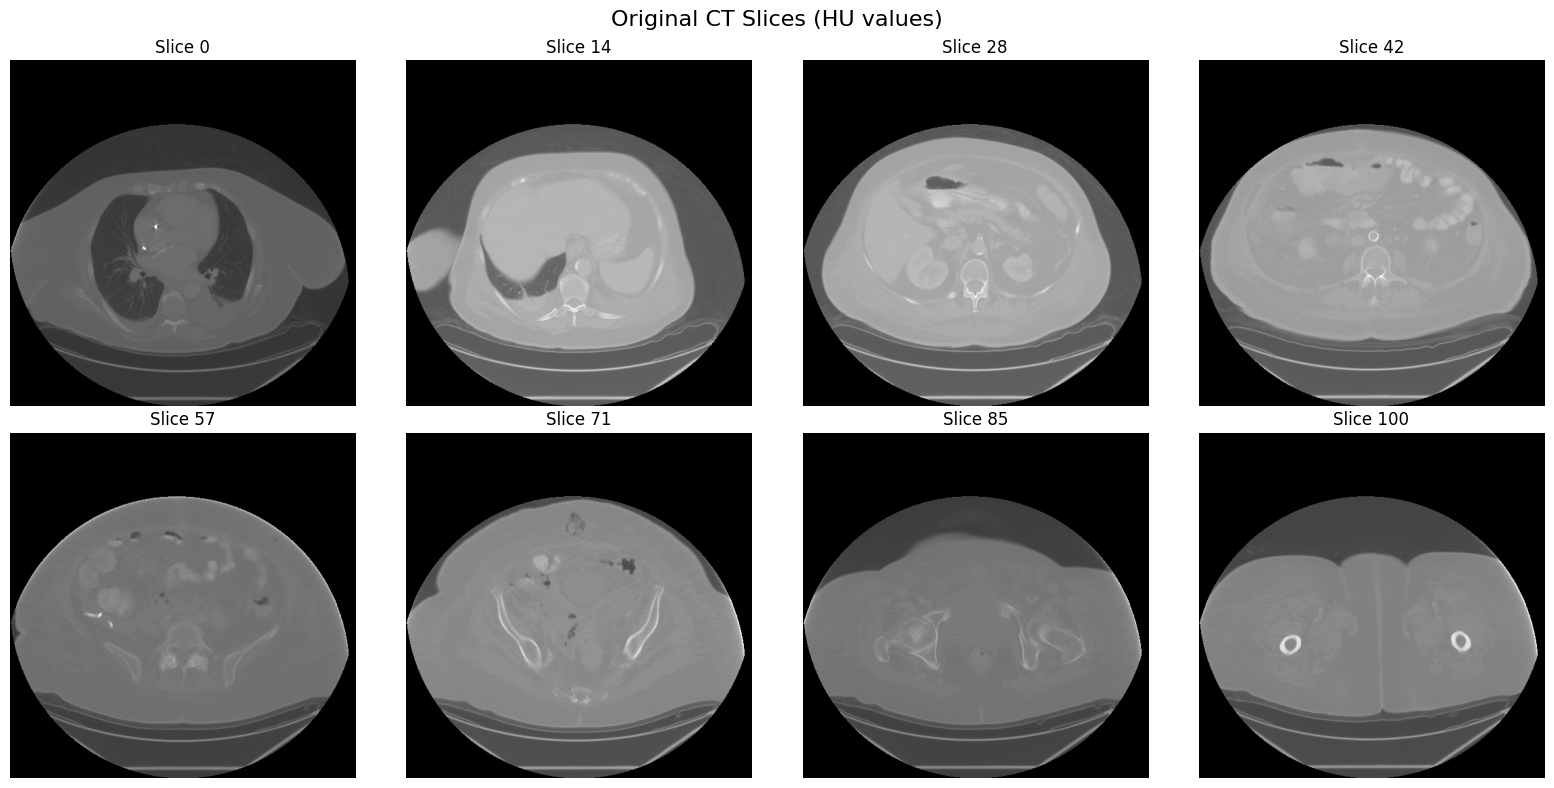

In [4]:
# Visualize some slices
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Select 8 evenly spaced slices
slice_indices = np.linspace(0, volume.shape[0]-1, 8, dtype=int)

for i, idx in enumerate(slice_indices):
    axes[i].imshow(volume[idx], cmap='gray')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

plt.suptitle('Original CT Slices (HU values)', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Preprocessing Components

### 3.1 Window/Level Adjustment

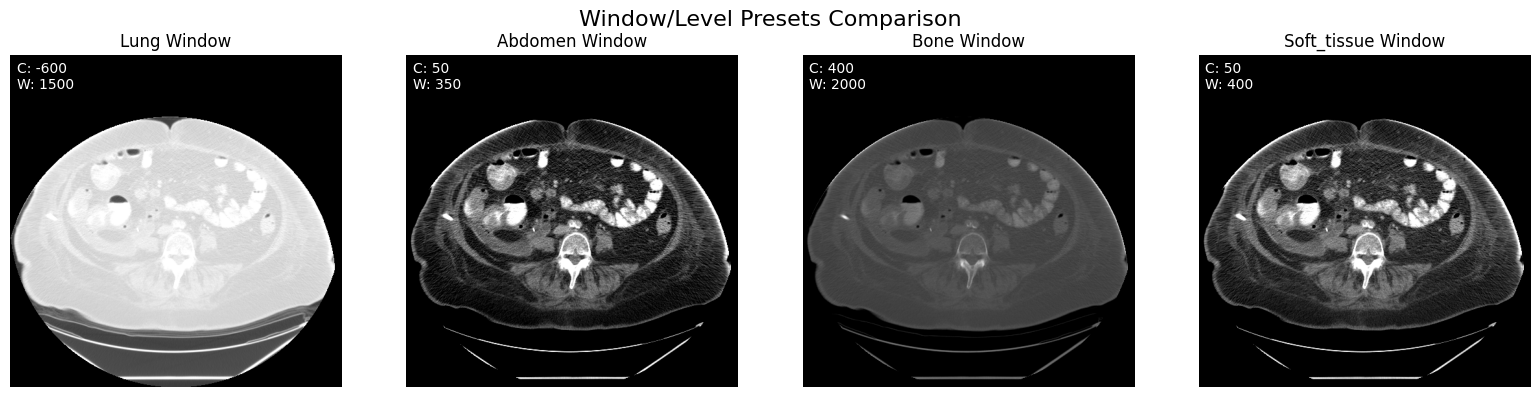

In [5]:
# Test different window presets
windower = WindowLevelAdjuster()
middle_slice = volume[volume.shape[0]//2]

# Apply different window presets
presets = ['lung', 'abdomen', 'bone', 'soft_tissue']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, preset in enumerate(presets):
    windowed = windower.adjust(middle_slice, window=preset)
    axes[i].imshow(windowed, cmap='gray')
    axes[i].set_title(f'{preset.capitalize()} Window')
    axes[i].axis('off')
    
    # Show window settings
    settings = windower.PRESETS[preset]
    axes[i].text(0.02, 0.98, f"C: {settings['center']}\nW: {settings['width']}", 
                transform=axes[i].transAxes, color='white', 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5),
                verticalalignment='top', fontsize=10)

plt.suptitle('Window/Level Presets Comparison', fontsize=16)
plt.tight_layout()
plt.show()

### 3.2 Denoising Methods

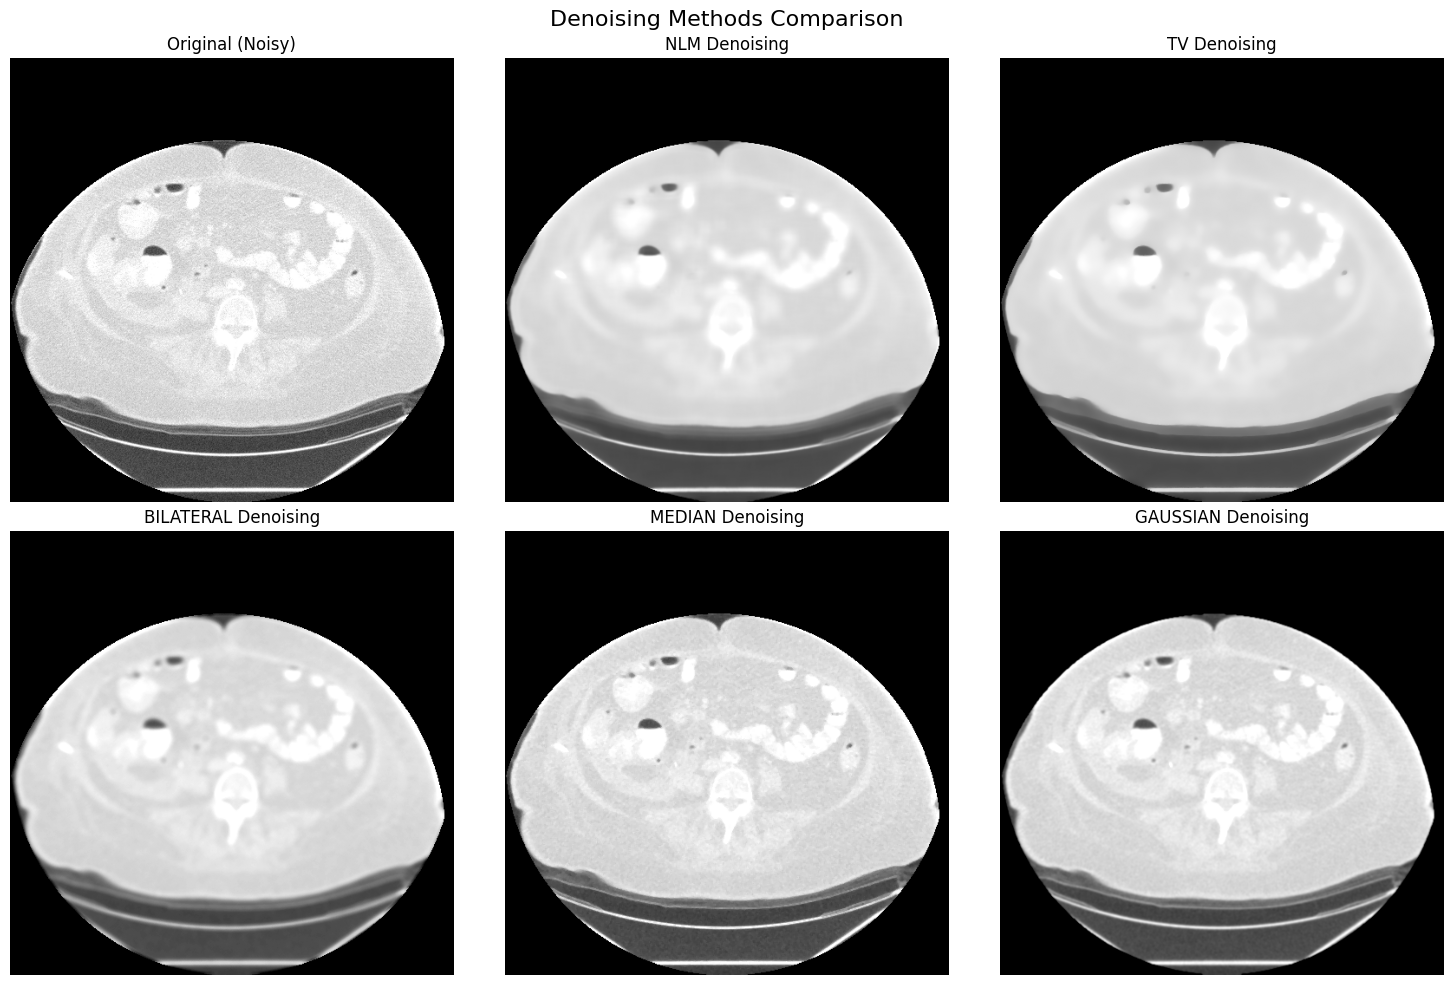

In [6]:
# Add some noise to demonstrate denoising
noisy_slice = middle_slice + np.random.normal(0, 50, middle_slice.shape)

# Test different denoising methods
methods = ['nlm', 'tv', 'bilateral', 'median', 'gaussian']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Original noisy image
windowed_noisy = windower.adjust(noisy_slice, window='lung')
axes[0].imshow(windowed_noisy, cmap='gray')
axes[0].set_title('Original (Noisy)')
axes[0].axis('off')

# Apply different denoising methods
for i, method in enumerate(methods):
    denoiser = Denoiser(method=method)
    denoised = denoiser.denoise(noisy_slice)
    windowed_denoised = windower.adjust(denoised, window='lung')
    
    axes[i+1].imshow(windowed_denoised, cmap='gray')
    axes[i+1].set_title(f'{method.upper()} Denoising')
    axes[i+1].axis('off')

plt.suptitle('Denoising Methods Comparison', fontsize=16)
plt.tight_layout()
plt.show()

### 3.3 Intensity Normalization

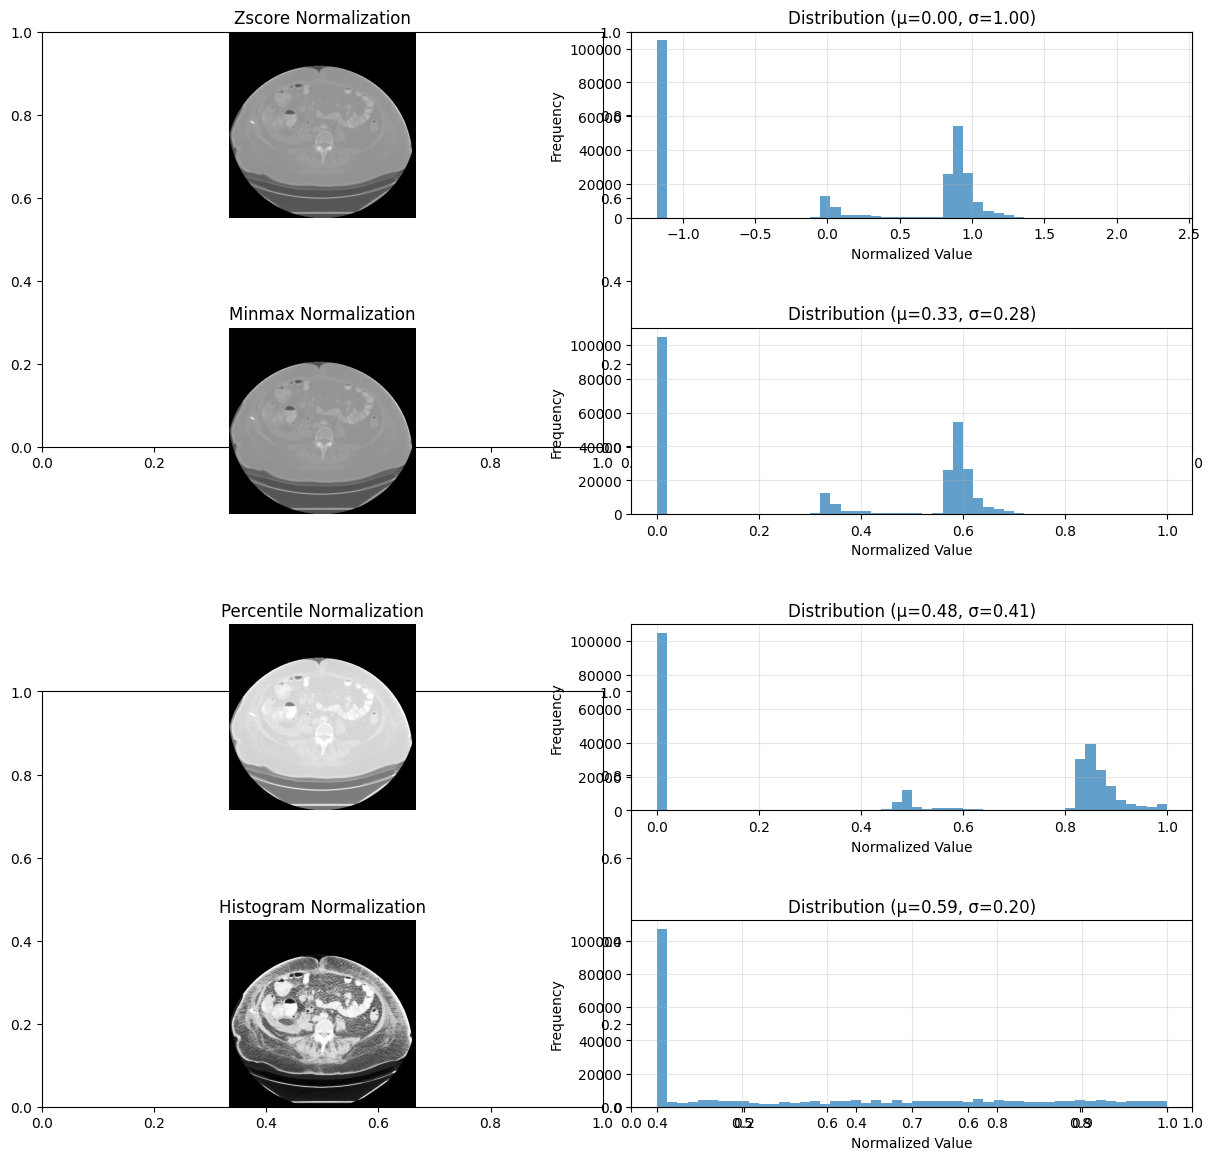

In [7]:
# Test normalization methods
methods = ['zscore', 'minmax', 'percentile', 'histogram']
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for i, method in enumerate(methods):
    normalizer = IntensityNormalizer(method=method)
    normalized = normalizer.normalize(middle_slice)
    
    # Plot image and histogram
    ax_img = plt.subplot(4, 2, i*2 + 1)
    ax_hist = plt.subplot(4, 2, i*2 + 2)
    
    # Image
    im = ax_img.imshow(normalized, cmap='gray')
    ax_img.set_title(f'{method.capitalize()} Normalization')
    ax_img.axis('off')
    
    # Histogram
    ax_hist.hist(normalized.flatten(), bins=50, alpha=0.7)
    ax_hist.set_xlabel('Normalized Value')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_title(f'Distribution (μ={normalized.mean():.2f}, σ={normalized.std():.2f})')
    ax_hist.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Complete CT Preprocessing Pipeline

Original volume: shape=(101, 512, 512), range=[-2048.0, 3072.0]
Preprocessed volume: shape=(101, 512, 512), range=[0.000, 1.000]


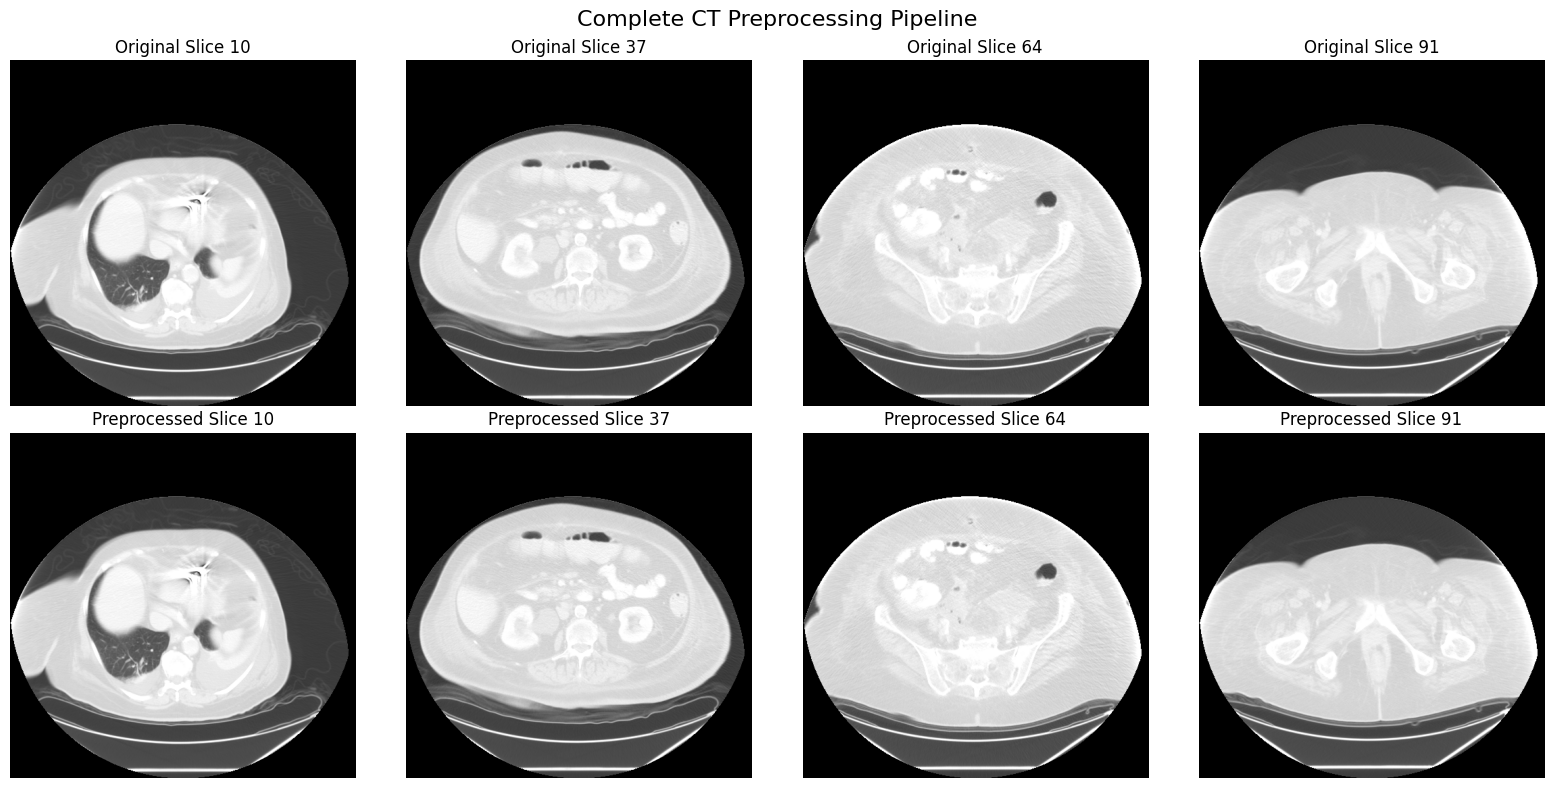

In [8]:
# Apply complete preprocessing pipeline
preprocessed_volume = preprocess_ct(
    volume,
    denoise=False,
    normalize=True,
    window='lung',
    reduce_artifacts=False
)

print(f"Original volume: shape={volume.shape}, range=[{volume.min():.1f}, {volume.max():.1f}]")
print(f"Preprocessed volume: shape={preprocessed_volume.shape}, range=[{preprocessed_volume.min():.3f}, {preprocessed_volume.max():.3f}]")

# Compare before and after
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Select 4 slices
slice_indices = np.linspace(10, volume.shape[0]-10, 4, dtype=int)

for i, idx in enumerate(slice_indices):
    # Original
    axes[0, i].imshow(windower.adjust(volume[idx], window='lung'), cmap='gray')
    axes[0, i].set_title(f'Original Slice {idx}')
    axes[0, i].axis('off')
    
    # Preprocessed
    axes[1, i].imshow(preprocessed_volume[idx], cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Preprocessed Slice {idx}')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=14)
axes[1, 0].set_ylabel('Preprocessed', fontsize=14)

plt.suptitle('Complete CT Preprocessing Pipeline', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Segmentation

In [9]:
# Initialize processor for segmentation
processor = RadiologyProcessor(model="radimagenet", use_hub=False)

# Segment lungs
print("Performing lung segmentation...")
lung_mask = processor.segment_lungs(volume)

print(f"✓ Lung mask shape: {lung_mask.shape}")
print(f"  Lung volume: {lung_mask.sum()} voxels")
print(f"  Percentage of volume: {100 * lung_mask.sum() / lung_mask.size:.1f}%")


INFO:honeybee.models.RadImageNet.radimagenet:Found model at default path: /mnt/d/Models/radimagenet/DenseNet121.pt
INFO:honeybee.models.RadImageNet.radimagenet:Successfully loaded model from: /mnt/d/Models/radimagenet/DenseNet121.pt
INFO:honeybee.processors.radiology.processor:RadiologyProcessor initialized with radimagenet model on cuda


Performing lung segmentation...
✓ Lung mask shape: (101, 512, 512)
  Lung volume: 211725 voxels
  Percentage of volume: 0.8%


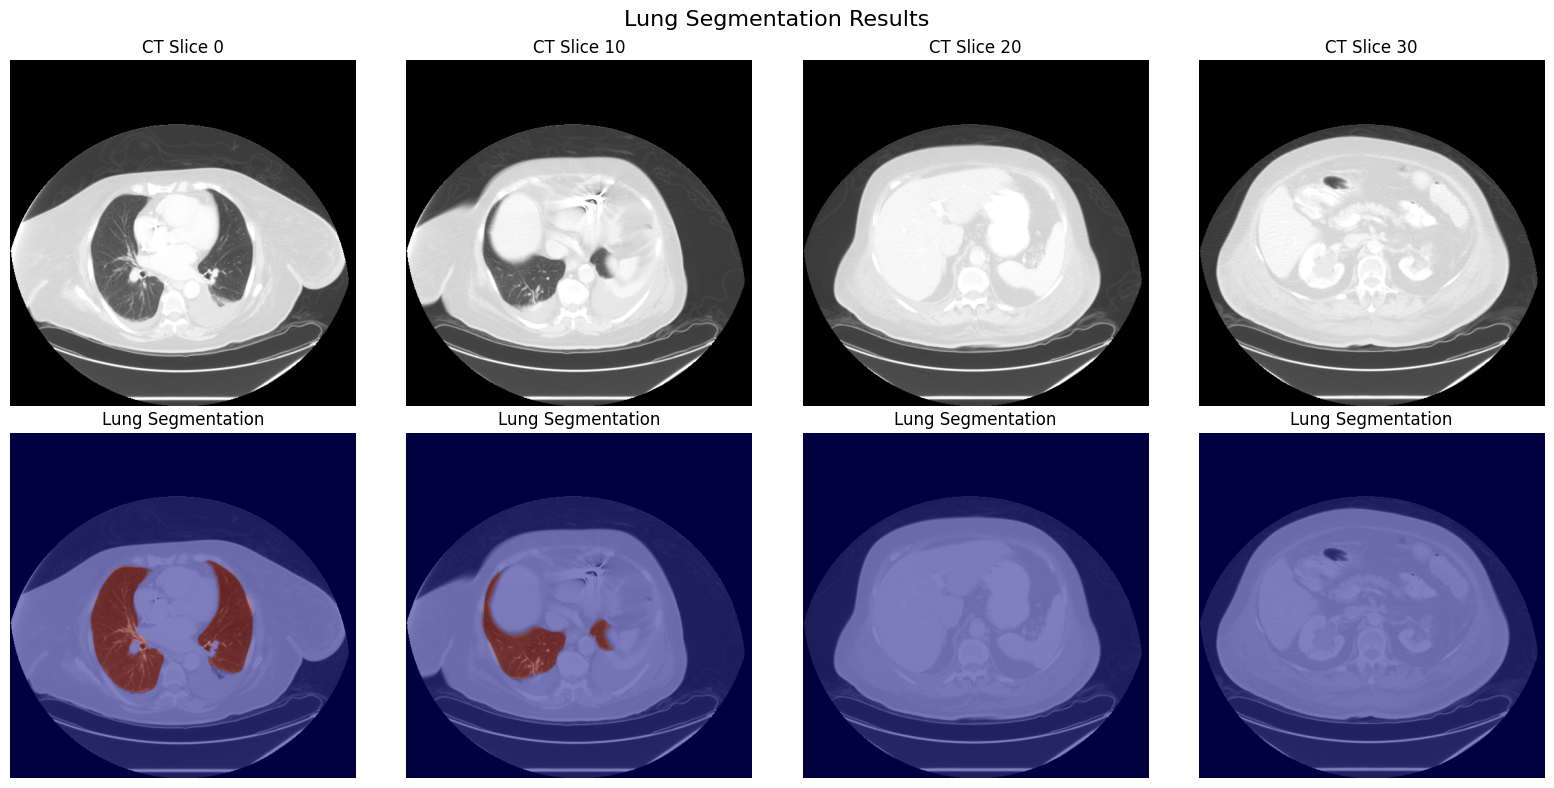

In [10]:
# Visualize segmentation results
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Select slices from different parts of the volume
slice_indices = [0, 10, 20, 30]

for i, idx in enumerate(slice_indices):
    # Original
    axes[0, i].imshow(windower.adjust(volume[idx], window='lung'), cmap='gray')
    axes[0, i].set_title(f'CT Slice {idx}')
    axes[0, i].axis('off')
    
    # Overlay segmentation
    axes[1, i].imshow(windower.adjust(volume[idx], window='lung'), cmap='gray')
    axes[1, i].imshow(lung_mask[idx], cmap='jet', alpha=0.5)
    axes[1, i].set_title(f'Lung Segmentation')
    axes[1, i].axis('off')

plt.suptitle('Lung Segmentation Results', fontsize=16)
plt.tight_layout()
plt.show()

## 6. RadImageNet Embeddings

In [11]:
# Initialize RadImageNet model
print("Initializing RadImageNet model...")
model = RadImageNet(
    model_name="DenseNet121",
    use_hub=False,
    extract_features=True
)
print(f"✓ Model loaded: {model.model_name}")
print(f"  Input size: {model.input_size}x{model.input_size}")
print(f"  Embedding dimension: {model.get_embedding_dim()}")

INFO:honeybee.models.RadImageNet.radimagenet:Found model at default path: /mnt/d/Models/radimagenet/DenseNet121.pt


Initializing RadImageNet model...


INFO:honeybee.models.RadImageNet.radimagenet:Successfully loaded model from: /mnt/d/Models/radimagenet/DenseNet121.pt


✓ Model loaded: DenseNet121
  Input size: 224x224
  Embedding dimension: 1024
